In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

## Load pre-trained AutoEncoder models 

In [5]:
# Define the custom objects with their corresponding classes
custom_objects = {
    'RectifiedAdam': tfa.optimizers.RectifiedAdam
}

In [ ]:
# Load the models with the custom optimizer
# model_1 = tf.keras.models.load_model('./AutoEncoder_original_epoch50/', custom_objects=custom_objects)
model_2 = tf.keras.models.load_model('./AutoEncoder/', custom_objects=custom_objects)

## Load datasets

In [3]:
import numpy as np

# Path to the saved preprocessed non-damage images
output_non_damage_path = './non_damage_preprocessed.npy'
# Path to the saved preprocessed damage images
output_damage_path = './damage_preprocessed.npy'

# Load the preprocessed non-damage images
non_damage_images = np.load(output_non_damage_path)
print("Non-damage images loaded. Shape:", non_damage_images.shape)

# Load the preprocessed damage images
damage_images = np.load(output_damage_path)
print("Damage images loaded. Shape:", damage_images.shape)

Non-damage images loaded. Shape: (6472, 128, 128, 1)
Damage images loaded. Shape: (7317, 128, 128, 1)


## Get Classification Model by adding classification layers

In [4]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

def get_classification_model(pretrained_model):
    # Use the output of the last encoder layer
    # Based on the summary of model_2
    # max_pooling2d is the last convolutional layer before the transpose convolution layers (conv2d_transpose)
    encoder_output = pretrained_model.get_layer('max_pooling2d').output

    # Flatten the output of the encoder
    flat = Flatten()(encoder_output)

    # Add classification layers
    classifier_layer = Dense(128, activation='relu')(flat)
    classifier_output = Dense(2, activation='softmax')(classifier_layer)

    # Create the classification model
    classifier_model = Model(inputs=pretrained_model.input, outputs=classifier_output)

    # Compile the model
    classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return classifier_model

# Create the classification model
model = get_classification_model(model_2)

In [5]:
# Prepare your dataset
X = np.concatenate((non_damage_images, damage_images), axis=0)
y = np.array([0] * len(non_damage_images) + [1] * len(damage_images))

SEED = 42

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Train the classifier
model.fit(X_train, y_train, epochs=10, batch_size=8)

# Evaluate the classifier
performance = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {performance[1]}')

Epoch 1/10
1379/1379 [==============================] - 32s 17ms/step - loss: 0.6940 - accuracy: 0.5861
Epoch 2/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.6046 - accuracy: 0.6595
Epoch 3/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.4398 - accuracy: 0.7728
Epoch 4/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.2377 - accuracy: 0.8870
Epoch 5/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.1166 - accuracy: 0.9528
Epoch 6/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.0656 - accuracy: 0.9764
Epoch 7/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.0381 - accuracy: 0.9882
Epoch 8/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.0259 - accuracy: 0.9931
Epoch 9/10
1379/1379 [==============================] - 23s 17ms/step - loss: 0.0317 - accuracy: 0.9918
Epoch 10/10
87/87 [==============================] - 2s 14ms/ste

In [6]:
# save classifier model
model.save('Classifier_model_2')

INFO:tensorflow:Assets written to: Classifier_model_2\assets


INFO:tensorflow:Assets written to: Classifier_model_2\assets


## Visulization of result

### Confusion Matrix

In [6]:
model = tf.keras.models.load_model('./Classifier_model_2/', custom_objects=custom_objects)

In [8]:
with tf.device('/cpu:0'):
    y_pred = model.predict(X_test, batch_size=8)
    y_pred_classes = np.argmax(y_pred, axis=1)


345/345 [==============================] - 14s 40ms/step


87/87 [==============================] - 1s 11ms/step


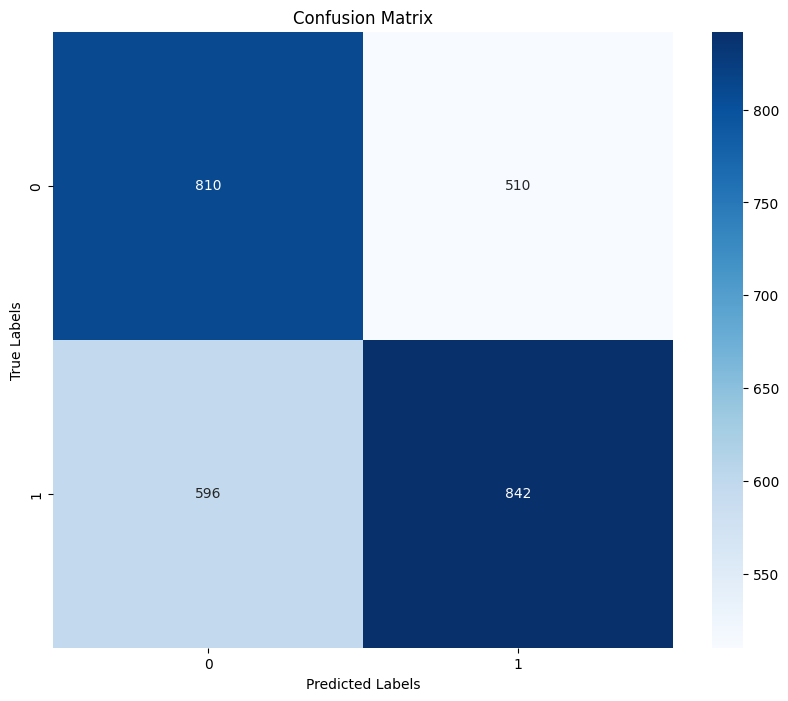

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Sample Predictions

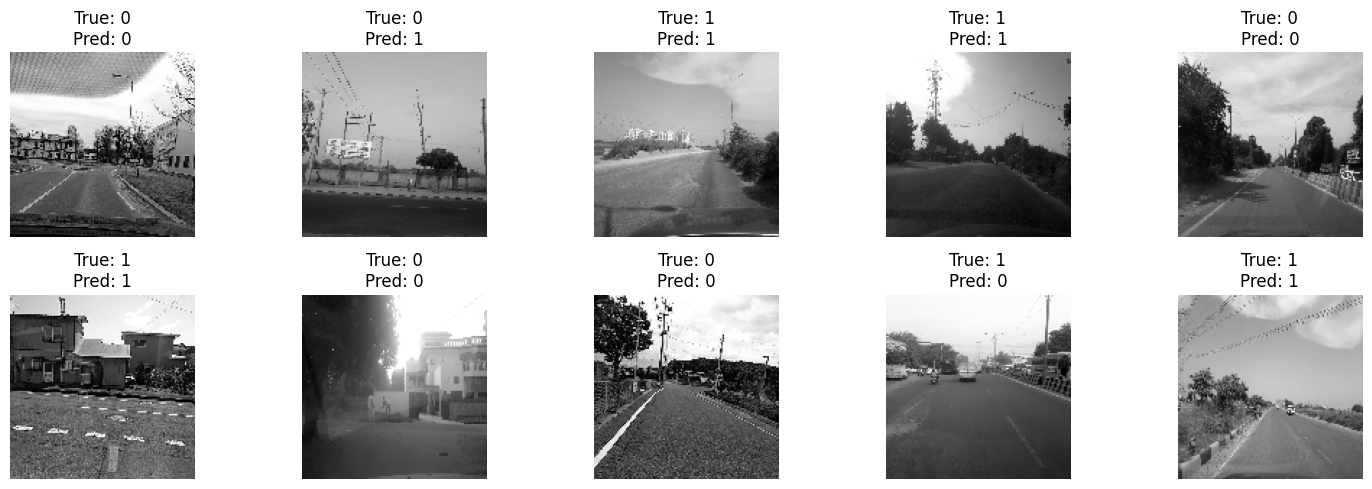

In [10]:
# Function to display images along with their true and predicted labels
def display_sample_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample predictions
num_samples = 10  # Number of samples you want to display
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]
sample_pred_labels = y_pred_classes[indices]

display_sample_predictions(sample_images, sample_true_labels, sample_pred_labels, num_images=num_samples)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# You should already have y_pred_classes from your model's predictions
# y_test contains the true labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
f1 = f1_score(y_test, y_pred_classes, average='binary')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5989847715736041
Precision: 0.6227810650887574
Recall: 0.5855354659248957
F1 Score: 0.6035842293906811


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                             